In [1]:
import tensorflow as tf
keras = tf.keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.sin(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

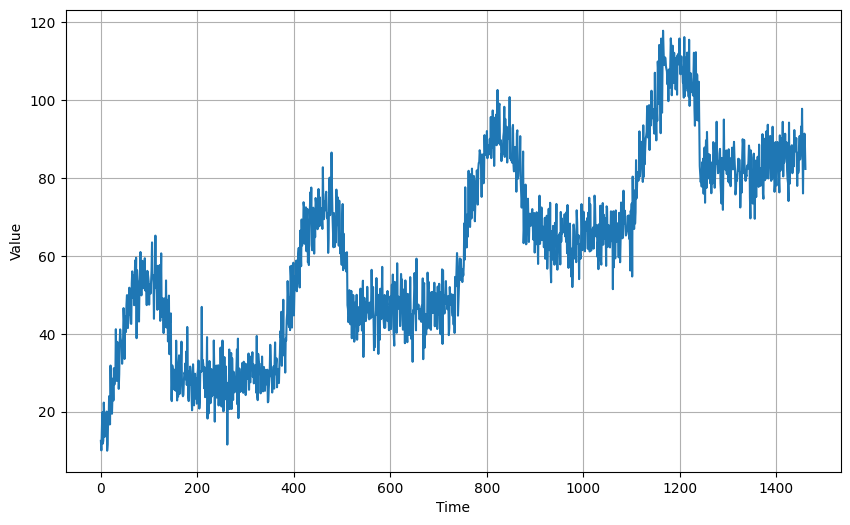

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

<b>RNN</b>

- Very powerful 
- Requires Data
- Tricky to train (somewhat unstable gradiet)

- Are Neural networks that contains a recurrent layer
- can sequencially process a sequence of input
- Three dimensional input
![Alt text](explanation_images/rnns.png)

- Single memory cell(Small NN) used repeatdly to compute the outputs.
- Single memory cell could be:
    - Simple Dense Layer
    - Complex: LSTM cell, GRU cell
 
Only single cell, in the diagram it's the same cell

- X0: input
- Y0 hat: current output
- H0: state or context factor, it's fed to the memory cell 

![Alt text](explanation_images/singlecCell.png)

- 4*3 becaue the batch size is 4, the # of steps (30) and the # of uits is 3
- H0 is just a copy of Y0... H1 is a copy of Y1

![Alt text](explanation_images/recurrentLayer.png)

- this is ignorong all the output except the last one
- will handle any sequences of any length  

![Alt text](explanation_images/seqToVector.png)

- The more steps the deeper it is
- training could be slow
![Alt text](explanation_images/bptt.png)

In [16]:
window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

In [8]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [9]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10 **(epoch/20)
)

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

In [11]:
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [12]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 228ms/step - loss: 45.3921 - mae: 45.8882 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 23.3522 - mae: 23.8494 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 20.7985 - mae: 21.2951 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 13.0945 - mae: 13.5859 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 7.5664 - mae: 8.0497 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 6.2879 - mae: 6.7717 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 5.9785 - mae: 6.4626 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 5.4062 - mae: 5.8892 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 5.2683 - mae: 5.7475 - lr: 2.5119e-07
E

In [13]:
early_stoping = keras.callbacks.EarlyStopping(patience=50)

In [20]:
model_checkpoint = keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)

In [ ]:
history = model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[early_stoping, model_checkpoint])

- to speed things up
- Sequence to sequnce RNN

![Alt text](explanation_images/seq2seq.png)

<b>Stateless and stateful RNNs</b>

<b>Long Short Term Cell</b>

- for longer sequences (rembers more)
- it has another state factor c

- forget gate (sigmoid + dense): when it multiply by 0 so it erases it.
- input gate (sigmoid + dense): decides when it's time to rember sth. (addition)
- output gate (sigmoid + dense): it learns which it should output next

![Alt text](explanation_images/lstm.png)

- generic is slower becaue it will run a lot of optimizers

In [22]:
keras.layers.RNN(keras.layers.LSTMCell(100))
keras.layers.LSTM

keras.src.layers.rnn.lstm.LSTM